## 1D Convnet Model on IMDB

In [1]:
# load IMDB data
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10_000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [3]:
# build and train 1D convnet model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                

2023-03-04 17:44:42.888054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - ETA: 0s - loss: 0.7511 - acc: 0.5278

2023-03-04 17:44:54.600997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 13s 77ms/step - loss: 0.7511 - acc: 0.5278 - val_loss: 0.6836 - val_acc: 0.5868
Epoch 2/10
157/157 [==============================] - 9s 55ms/step - loss: 0.6636 - acc: 0.6781 - val_loss: 0.6575 - val_acc: 0.6790
Epoch 3/10
157/157 [==============================] - 9s 59ms/step - loss: 0.6142 - acc: 0.7720 - val_loss: 0.5944 - val_acc: 0.7390
Epoch 4/10
157/157 [==============================] - 9s 56ms/step - loss: 0.5105 - acc: 0.8197 - val_loss: 0.4683 - val_acc: 0.8104
Epoch 5/10
157/157 [==============================] - 8s 54ms/step - loss: 0.3885 - acc: 0.8563 - val_loss: 0.4048 - val_acc: 0.8384
Epoch 6/10
157/157 [==============================] - 8s 50ms/step - loss: 0.3299 - acc: 0.8815 - val_loss: 0.3964 - val_acc: 0.8594
Epoch 7/10
157/157 [==============================] - 7s 47ms/step - loss: 0.2892 - acc: 0.8971 - val_loss: 0.3932 - val_acc: 0.8666
Epoch 8/10
157/157 [==============================] - 7s 47ms/step - loss: 0.26

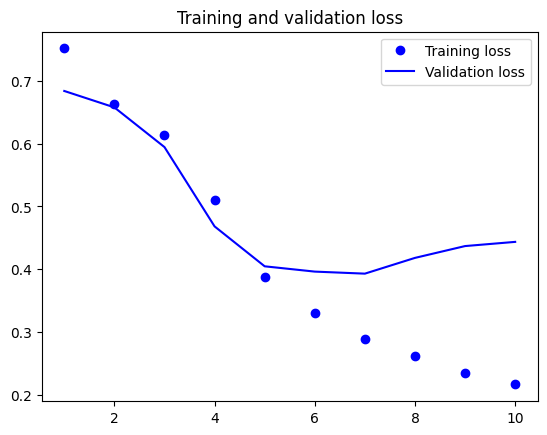

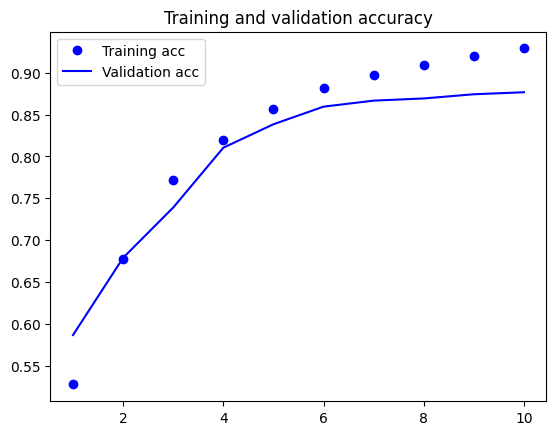

In [4]:
# plot training / validation loss and accuracy
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

## 1D Convnet on Weather

In [2]:
# load Jena weather data (same as 6.3)
import os

data_path = os.path.join(os.getcwd(), 'jena_climate_2009_2016.csv')
file = open(data_path)
data = file.read()
file.close()

lines = data.split('\n')
headers = lines[0].split(',')
lines = lines[1:]


# convert data to np array
import numpy as np

float_data = np.zeros((len(lines), len(headers) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i] = values


# normalize data based on first 200,000 data points (only training data)
mean = float_data[:200_000].mean(axis=0)
std = float_data[:200_000].std(axis=0)
float_data -= mean
float_data /= std


# function to create generator to return timeseries samples and their targets
def generator(data, lookback, delay, min_index=None, max_index=None,
              shuffle=False, batch_size=128, step=6):
    if min_index == None:
        min_index = 0
    if max_index == None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros(len(rows))
        for j, row in enumerate(rows):
            indices = range(row - lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row + delay][1]
        yield samples, targets


# create training / validation / test generators
lookback = 1440
delay = 144
batch_size = 128
step = 6

train_gen = generator(float_data, lookback=lookback, delay=delay, max_index=200_000, shuffle=True)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200_001, max_index=300_000)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300_001)

val_steps = (300_000 - 200_001 - lookback) // batch_size
test_steps = (len(float_data) - 300_001 - lookback) // batch_size

In [3]:
# build and train 1D convnet model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

2023-03-11 17:01:37.142610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-11 17:01:37.142769: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-11 17:01:37.318718: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/20


2023-03-11 17:01:37.630589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


495/500 [============================>.] - ETA: 0s - loss: 0.4213

2023-03-11 17:01:43.265451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 9s 17ms/step - loss: 0.4206 - val_loss: 0.4393
Epoch 2/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3609 - val_loss: 0.4534
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3382 - val_loss: 0.4542
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3203 - val_loss: 0.4602
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3090 - val_loss: 0.4538
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2975 - val_loss: 0.4485
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2908 - val_loss: 0.4597
Epoch 8/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2830 - val_loss: 0.4507
Epoch 9/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2774 - val_loss: 0.4611
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2722 - val_loss: 0.4633


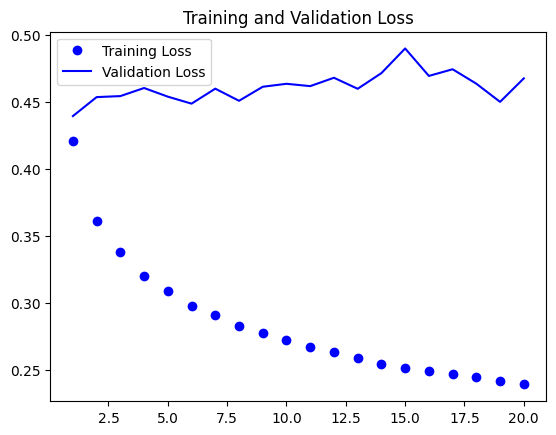

In [4]:
# plot training / validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## 1D Convnet and GRU model on Weather

In [2]:
# create higher-resolution generators
lookback = 720
delay = 144
batch_size = 128
step = 3 # down from 6 -> data every 30min instead of 1hr

train_gen = generator(float_data, lookback=lookback, delay=delay, max_index=200_000, shuffle=True)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200_001, max_index=300_000)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300_001)

val_steps = (300_000 - 200_001 - lookback) // batch_size
test_steps = (len(float_data) - 300_001 - lookback) // batch_size

In [3]:
# Build and train 1D Convnet and GRU model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GRU(32, dropout=0.51, recurrent_dropout=0.5))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

model.summary()

import tensorflow as tf
with tf.device('/CPU:0'): # kernel was crashing with GPU
    history = model.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=20,
                        validation_data=val_gen,
                        validation_steps=val_steps)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-04 18:06:49.377786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-04 18:06:49.378046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          2272      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
____________________________________________________

2023-03-04 18:06:49.641259: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-04 18:06:50.520353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 0.3643

2023-03-04 18:07:10.458011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 38s 73ms/step - loss: 0.3643 - val_loss: 0.3114
Epoch 2/20
500/500 [==============================] - 37s 73ms/step - loss: 0.3277 - val_loss: 0.3011
Epoch 3/20
500/500 [==============================] - 38s 76ms/step - loss: 0.3156 - val_loss: 0.2879
Epoch 4/20
500/500 [==============================] - 37s 73ms/step - loss: 0.3028 - val_loss: 0.3018
Epoch 5/20
500/500 [==============================] - 37s 74ms/step - loss: 0.2966 - val_loss: 0.2868
Epoch 6/20
500/500 [==============================] - 37s 75ms/step - loss: 0.2895 - val_loss: 0.2916
Epoch 7/20
500/500 [==============================] - 38s 77ms/step - loss: 0.2838 - val_loss: 0.3030
Epoch 8/20
500/500 [==============================] - 39s 78ms/step - loss: 0.2766 - val_loss: 0.2933
Epoch 9/20
500/500 [==============================] - 38s 77ms/step - loss: 0.2720 - val_loss: 0.2926
Epoch 10/20
500/500 [==============================] - 39s 78ms/step - loss: 0.2698 - val_los

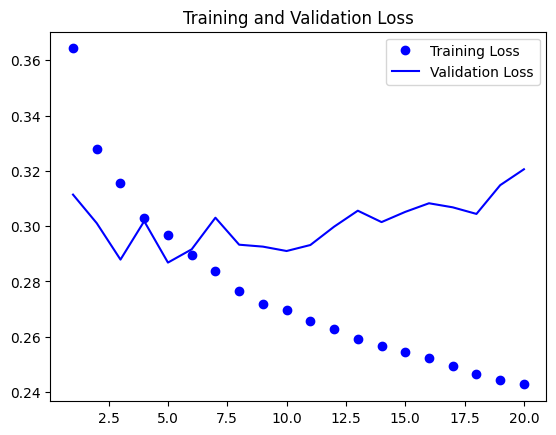

In [4]:
# plot training / validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [5]:
# evaluate final model

import tensorflow as tf
with tf.device('/CPU:0'): # kernel was crashing with GPU
    model.evaluate(test_gen, steps=test_steps)

935/935 [==============================] - 22s 24ms/step - loss: 0.3422
